In [98]:
import pandas as pd
import spacy
import textacy
import os
import logging
HOME = os.getcwd()
df = pd.read_csv(os.path.join(HOME, 'ethics_statement_frontiers_1000_spacy.csv'), usecols = ['parsed'])
#preproc = textacy.preprocessing.make_pipeline(textacy.preprocessing.normalize.unicode,textacy.preprocessing.normalize.quotation_marks,textacy.preprocessing.normalize.whitespace)
#preproc_records = ((preproc(text), meta) for text, meta in records)
parsed_paragraphs= df.parsed.to_list()

#Removing empty cells in the csv
new_parsed_paragraphs = []
for parsed_paragraph in parsed_paragraphs:
    if type(parsed_paragraph) == str :
        new_parsed_paragraphs.append(parsed_paragraph)
        
for new_parsed_paragraph in new_parsed_paragraphs:
    new_parsed_paragraph.encode().decode("utf-8")

corpus = textacy.Corpus("en_core_web_sm", data=new_parsed_paragraphs)


In [99]:
print(corpus)

Corpus(477 docs, 19057 tokens)


In [ ]:
import pandas as pd
import spacy
import textacy
import os
import logging
HOME = os.getcwd()
df = pd.read_csv(os.path.join(HOME, 'ethics_statement_frontiers_100.csv'), usecols = ['parsed'])
#print(df)
parsed_ethics_statement = df.parsed.to_list()
df_intro = pd.read_csv(os.path.join(HOME,'ethics_statement_Hindawi_50_20210708.csv'), usecols = ['parsed'])
#print(df)
parsed_intro = df_intro.parsed.to_list()
combined_parsed = parsed_ethics_statement + parsed_intro
for parsed_paragraph in combined_parsed:
    parsed_paragraph.encode().decode("utf-8")
corpus = textacy.Corpus("en_core_web_sm", data=combined_parsed)
print(corpus)

In [8]:
import textacy.extract
list(textacy.extract.entities(corpus[0]))

[Ethics Committee of Endocrinology,
 Metabolism Research Institute,
 Tehran University of Medical Sciences (Code]

In [12]:
from functools import partial
terms = list(textacy.extract.terms(
     corpus[0],
     ngs=partial(textacy.extract.ngrams, n=2, include_pos={"NOUN", "ADJ", 'VERB'}),ents=partial(textacy.extract.entities, include_types={"PERSON", "ORG", "GPE", "LOC"}),dedupe=False),)
terms


[animal study,
 Ethics Committee of Endocrinology,
 Metabolism Research Institute,
 Tehran University of Medical Sciences (Code]

In [13]:
list(textacy.extract.terms_to_strings(terms, by="lemma"))


['animal study',
 'Ethics Committee of Endocrinology',
 'Metabolism Research Institute',
 'Tehran University of Medical Sciences ( code']

In [40]:
docs_terms = (
     textacy.extract.terms(
         doc,
         ngs=partial(textacy.extract.ngrams, n=2, include_pos={"NOUN", "ADJ"}),
         ents=partial(textacy.extract.entities, include_types={"PERSON", "GPE",}))
     for doc in corpus)
tokenized_docs = (
     textacy.extract.terms_to_strings(doc_terms, by="lemma")
     for doc_terms in docs_terms)

In [41]:
import textacy.representations
doc_term_matrix, vocab = textacy.representations.build_doc_term_matrix(tokenized_docs, tf_type="linear", idf_type="smooth")
doc_term_matrix

<477x347 sparse matrix of type '<class 'numpy.float64'>'
	with 1389 stored elements in Compressed Sparse Row format>

In [74]:
import textacy.tm
model = textacy.tm.TopicModel("nmf", n_topics=4)
model.fit(doc_term_matrix)

c:\users\shweata\appdata\local\programs\python\python38\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [75]:
doc_topic_matrix = model.transform(doc_term_matrix)
doc_topic_matrix.shape

(477, 4)

In [76]:
doc_topic_matrix

array([[0.        , 0.        , 0.19961044, 0.        ],
       [0.24081956, 0.01443823, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       ...,
       [0.24728968, 0.01275726, 0.        , 0.        ],
       [0.41362149, 0.        , 0.        , 0.        ],
       [0.1265744 , 0.        , 0.        , 0.66515285]])

In [77]:
id_to_term = {id_: term for term, id_ in vocab.items()}
for topic_idx, terms in model.top_topic_terms(id_to_term, top_n=8):
     print(f"topic {topic_idx}: {'   '.join(terms)}")

topic 0: informed consent   human participant   legal guardian   identifiable image   ethic committee   review board   institutional review   ethical committee
topic 1: institutional requirement   national legislation   ethical review   local legislation   informed consent   human participant   approval number   ethic approval
topic 2: animal study   China   Shanghai   approval number   Guangzhou   animal experiment   experimental procedure   strict accordance
topic 3: ethic committee   local ethic   base surgery   surgical specimen   Etikprövningsnämnden Uppsala   posterior cranial   patient consent   major trans


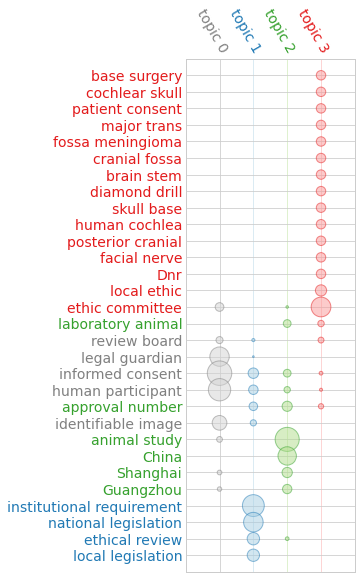

In [78]:
_ = model.termite_plot(doc_term_matrix, id_to_term, n_terms=30, highlight_topics=[1,2,3,4])